# Libraries

In [ ]:
!pip install mediapipe opencv-python numpy pandas scikit-learn tqdm matplotlib seaborn

     --------------------------------------- 39.5/39.5 MB 43.7 MB/s eta 0:00:00
     --------------------------------------- 51.0/51.0 MB 54.7 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
  Using cached absl_py-2.3.0-py3-none-any.whl (135 kB)
  Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
  Using cached jax-0.6.2-py3-none-any.whl (2.7 MB)
     --------------------------------------- 57.9/57.9 MB 18.7 MB/s eta 0:00:00
     --------------------------------------- 15.8/15.8 MB 73.0 MB/s eta 0:00:00
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl (46.2 MB)
     ------------------------------------- 413.7/413.7 kB 25.2 MB/s eta 0:00:00
  Using cached sounddevice-0.5.2-py3-none-win_amd64.whl (363 kB)
     ------------------------------------- 991.5/991.5 kB 61.3 MB/s eta 0:00:00
     ------------------------------------- 181.4/181.4 kB 10.7 MB/s eta 0:00:00
     ------------------------------------- 209.7/209.7 kB 12.5

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python311\\Scripts\\tqdm.exe' -> 'C:\\Python311\\Scripts\\tqdm.exe.deleteme'


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Import libraries for pose estimation, video processing, and data manipulation
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Import scikit-learn tools for SVM, scaling, splitting, and evaluation
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import utilities for real-time inference and logging
import time
import datetime
import csv
import threading

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

print("Libraries imported successfully!")

Libraries imported successfully!


# Helper Functions

In [ ]:
# Define preprocessing functions

# Define label mapping
LABEL_MAP = {'Arm Raise Incorrect': 0, 'Arm Raise Correct': 1}

def extract_landmarks(frame):
    """Extract pose landmarks from a frame using MediaPipe."""
    # Convert frame to RGB (MediaPipe requirement)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Process frame to detect landmarks
    results = pose.process(frame_rgb)
    if results.pose_landmarks:  # Use pose_landmarks
        # Flatten landmarks into a 132D vector (33 landmarks x [x, y, z, visibility])
        landmarks = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]).flatten()
        return landmarks, results.pose_landmarks  # Return pose_landmarks
    return None, None

def compute_angle(a, b, c):
    """Compute angle at point b between points a and c."""
    a = np.array(a[:2])  # Use x, y coordinates
    b = np.array(b[:2])
    c = np.array(c[:2])
    ab = a - b
    bc = c - b
    cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0)) * 180 / np.pi
    return angle

def compute_distance(a, b):
    """Compute Euclidean distance between two landmarks."""
    a = np.array(a[:3])  # Use x, y, z
    b = np.array(b[:3])
    return np.linalg.norm(a - b)

def normalize_landmarks(landmarks):
    """Normalize landmarks by centering and scaling."""
    landmarks = landmarks.reshape(33, 4)
    # Use shoulders as reference points
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    # Compute torso midpoint and shoulder width
    torso_midpoint = (left_shoulder[:3] + right_shoulder[:3]) / 2
    shoulder_width = compute_distance(left_shoulder, right_shoulder)
    # Center landmarks by subtracting torso midpoint
    normalized = landmarks.copy()
    normalized[:, :3] -= torso_midpoint
    # Scale x, y, z by shoulder width (preserve visibility)
    normalized[:, :3] /= shoulder_width if shoulder_width > 0 else 1
    return normalized.flatten()

def extract_features(frame):
    """Extract features from a frame (normalized landmarks + angles + distances)."""
    landmarks, landmark_obj = extract_landmarks(frame)
    if landmarks is None:
        return None
    # Normalize landmarks
    norm_landmarks = normalize_landmarks(landmarks)
    # Compute additional features
    if landmark_obj:
        # Extract landmark coordinates as arrays
        left_shoulder = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                                  landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y,
                                  landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value].z])
        left_elbow = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                               landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value].y,
                               landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value].z])
        left_wrist = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                               landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_WRIST.value].y,
                               landmark_obj.landmark[mp_pose.PoseLandmark.LEFT_WRIST.value].z])
        right_shoulder = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                                   landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y,
                                   landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].z])
        right_elbow = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                                landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y,
                                landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value].z])
        right_wrist = np.array([landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                                landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_WRIST.value].y,
                                landmark_obj.landmark[mp_pose.PoseLandmark.RIGHT_WRIST.value].z])
        # Elbow angles
        left_elbow_angle = compute_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = compute_angle(right_shoulder, right_elbow, right_wrist)
        # Normalized shoulder-to-wrist distances
        shoulder_width = compute_distance(left_shoulder, right_shoulder)
        left_distance = compute_distance(left_shoulder, left_wrist) / shoulder_width if shoulder_width > 0 else 1
        right_distance = compute_distance(right_shoulder, right_wrist) / shoulder_width if shoulder_width > 0 else 1
        # Combine features: 132D normalized landmarks + 2 angles + 2 distances
        features = np.concatenate([norm_landmarks, [left_elbow_angle, right_elbow_angle, left_distance, right_distance]])
        return features
    return None

def process_video(video_path, frame_skip=5):
    """Process a video to extract average features across frames."""
    cap = cv2.VideoCapture(video_path)
    features_list = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            features = extract_features(frame)
            if features is not None:
                features_list.append(features)
        frame_count += 1
    cap.release()
    if features_list:
        # Average features across frames
        return np.mean(features_list, axis=0)
    return None

def preprocess_dataset(dataset_path, frame_skip=5):
    """Preprocess dataset to extract features and labels."""
    X, y = [], []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path) and class_name in LABEL_MAP:
            label = LABEL_MAP[class_name]
            for video_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
                video_path = os.path.join(class_path, video_name)
                features = process_video(video_path, frame_skip)
                if features is not None:
                    X.append(features)
                    y.append(label)
    return np.array(X), np.array(y)

# Preprocess Dataset

In [ ]:
# Load and preprocess dataset
# Define dataset paths
train_path = 'dataset_small_50/train'
val_path = 'dataset_small_50/val'
test_path = 'dataset_small_50/test'

# Preprocess training, validation, and test datasets
print("Preprocessing training dataset...")
X_train, y_train = preprocess_dataset(train_path, frame_skip=5)
print("Preprocessing validation dataset...")
X_val, y_val = preprocess_dataset(val_path, frame_skip=5)
print("Preprocessing test dataset...")
X_test, y_test = preprocess_dataset(test_path, frame_skip=5)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print dataset statistics
print(f"Training set: {X_train.shape[0]} samples, {np.bincount(y_train)} (Incorrect, Correct)")
print(f"Validation set: {X_val.shape[0]} samples, {np.bincount(y_val)} (Incorrect, Correct)")
print(f"Test set: {X_test.shape[0]} samples, {np.bincount(y_test)} (Incorrect, Correct)")

Preprocessing training dataset...


Processing Arm Raise Incorrect: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


Preprocessing validation dataset...


Processing Arm Raise Incorrect: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Preprocessing test dataset...


Processing Arm Raise Incorrect: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

Training set: 80 samples, [40 40] (Incorrect, Correct)
Validation set: 10 samples, [5 5] (Incorrect, Correct)
Test set: 10 samples, [5 5] (Incorrect, Correct)


# Training Random Forest Model

In [32]:
# Define and train SVM model with hyperparameter tuning
# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

# Initialize SVM classifier
svm = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print results
print("Best Parameters:", best_params)
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
Cross-Validation Accuracy: 0.7625
Validation Accuracy: 0.7000


# Evaluate Model

Test Set Evaluation:
Accuracy: 0.8000
Precision: 0.7143
Recall: 1.0000
F1-Score: 0.8333

Classification Report:
              precision    recall  f1-score   support

   Incorrect       1.00      0.60      0.75         5
     Correct       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



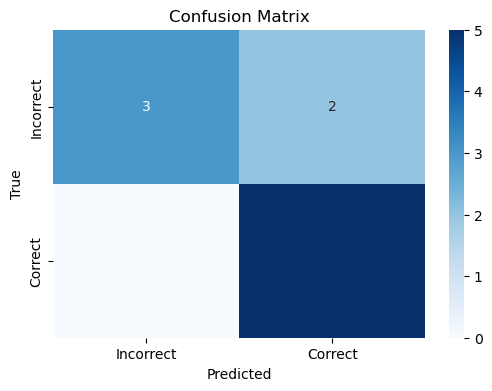

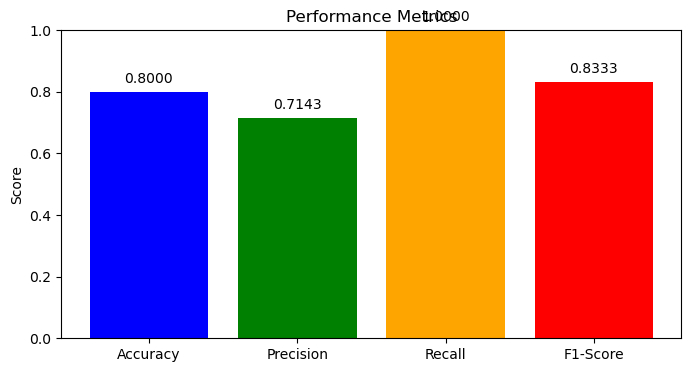

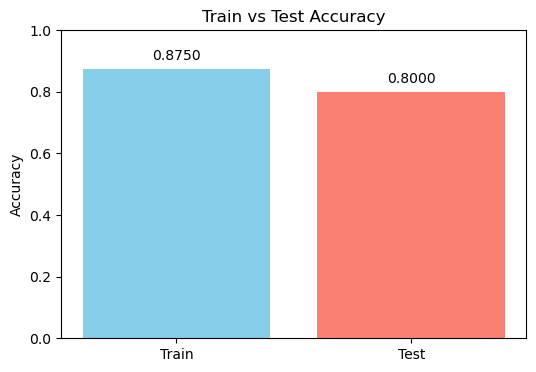

Confusion Matrix:
 [[3 2]
 [0 5]]
Test Set Accuracy: 0.8
Training Set Accuracy (actual): 0.875
Training Set CV Mean Accuracy (cross-validation): 0.7625


In [33]:
# Evaluate model on test set
# Predict on test set
y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

# Compute metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)  # <-- Actual train accuracy

# Print metrics
print("Test Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Incorrect', 'Correct']))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Incorrect', 'Correct'], yticklabels=['Incorrect', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize performance metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
plt.figure(figsize=(8, 4))
bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom')
plt.show()

# Plot train vs test accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Test'], [train_accuracy, accuracy], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
for i, v in enumerate([train_accuracy, accuracy]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')
plt.show()

# Print confusion matrix and accuracies for reference
print("Confusion Matrix:\n", cm)
print("Test Set Accuracy:", accuracy)
print("Training Set Accuracy (actual):", train_accuracy)
print("Training Set CV Mean Accuracy (cross-validation):", best_score)

In [34]:
# print confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[3 2]
 [0 5]]


# Real-Time Inference

In [15]:
# Cell 1: Define real-time inference functions
def draw_arm_skeleton(frame, landmarks):
    """Draw arm skeleton on the frame."""
    if landmarks:
        # Define arm connections (shoulder-elbow, elbow-wrist)
        connections = [
            (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
            (mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
            (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
            (mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST)
        ]
        # Draw lines
        for start, end in connections:
            start_lm = landmarks.landmark[start.value]  # Use landmark list
            end_lm = landmarks.landmark[end.value]
            cv2.line(frame, (int(start_lm.x * frame.shape[1]), int(start_lm.y * frame.shape[0])),
                     (int(end_lm.x * frame.shape[1]), int(end_lm.y * frame.shape[0])), (255, 255, 255), 2)
        # Draw circles at joints
        for idx in [11, 12, 13, 14, 15, 16]:  # Shoulder, elbow, wrist indices
            lm = landmarks.landmark[idx]
            cv2.circle(frame, (int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])), 5, (255, 0, 0), -1)
    return frame

def init_csv_log():
    """Initialize CSV log file with timestamp."""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = f"postureguardian_log_{timestamp}.csv"
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Timestamp', 'Prediction'])
    return log_file

def inference_thread(model, scaler, cap, frame_skip, window_size, log_file, predictions, stop_event):
    """Run inference in a separate thread."""
    feature_window = []
    frame_count = 0
    while not stop_event.is_set():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            features = extract_features(frame)
            if features is not None:
                # Scale features
                features = scaler.transform([features])
                # Predict
                pred = model.predict(features)[0]
                feature_window.append(pred)
                if len(feature_window) > window_size:
                    feature_window.pop(0)
                # Smooth prediction
                if feature_window:
                    smoothed_pred = 1 if np.mean(feature_window) > 0.5 else 0
                    predictions[0] = smoothed_pred
                    # Log prediction
                    with open(log_file, 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"), 'Correct' if smoothed_pred == 1 else 'Incorrect'])
        frame_count += 1

# Cell 2: Real-time inference
def real_time_inference(model, scaler, frame_skip=3, window_size=10):
    """Perform real-time inference with webcam input."""
    print("Starting real-time inference (press 'q' to quit)...")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    # Initialize logging and threading
    log_file = init_csv_log()
    predictions = [0]  # Shared list for thread communication
    stop_event = threading.Event()
    thread = threading.Thread(target=inference_thread, args=(model, scaler, cap, frame_skip, window_size, log_file, predictions, stop_event))
    thread.start()

    # FPS measurement
    fps_list = []
    start_time = time.time()
    avg_fps = 0  # Initialize avg_fps to handle early termination

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Get current prediction
            pred = predictions[0]
            # Draw label
            label = 'Correct' if pred == 1 else 'Incorrect'
            color = (0, 255, 0) if pred == 1 else (0, 0, 255)
            cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            # Draw arm skeleton
            _, landmarks = extract_landmarks(frame)
            frame = draw_arm_skeleton(frame, landmarks)
            # Display frame
            cv2.imshow('PostureGuardian', frame)
            # Calculate FPS
            fps_list.append(time.time())
            if len(fps_list) > 10:
                fps_list.pop(0)
                avg_fps = len(fps_list) / (fps_list[-1] - fps_list[0]) if len(fps_list) > 1 else 0
            # Check for quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        stop_event.set()
        thread.join()
        cap.release()
        cv2.destroyAllWindows()
        print(f"Average FPS: {avg_fps:.2f}")
        print(f"Results logged to {log_file}")

# Run real-time inference
real_time_inference(best_model, scaler, frame_skip=3, window_size=10)

Starting real-time inference (press 'q' to quit)...
Average FPS: 11.25
Results logged to postureguardian_log_20250625_112307.csv
